### driftkit

LLM-powered pyschogeographic exploration.

In [2]:
! pip install --quiet -r requirements.txt 

In [3]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

True

In [5]:
from typing import List

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.prebuilt import ToolNode

@tool(parse_docstring=True)
def navigate(
    from_lat: float,
    from_lon: float,
    location_id: str,
    config: RunnableConfig,
) -> None:
    """Navigate to a location.

    Args:
        location_id: ID of the location to navigate to.
    """
    navigator = config.get("configurable", {}).get("navigator")
    navigation_result = navigator.navigate(from_lat, from_lon, location_id)
    return {
            "tool_message": navigation_result["message"], 
            "current_location": navigation_result["current_location"],
            "walking_directions": navigation_result["walking_directions"]
            }

@tool
def get_next_possible_destinations(from_lat: float, from_lon: float, config: RunnableConfig) -> None:
    """Get next possible destinations."""
    navigator = config.get("configurable", {}).get("navigator")
    result = navigator.get_next_possible_destinations(from_lat, from_lon)
    
    if result["status"] == "complete":
        return {"tool_message": "Your route is complete. You have visited all possible locations."}

    if result["status"] != "success":
        return {"tool_message": "Failed to get next possible destinations."}
    
    destinations = result["destinations"]
    destinations_list = "\n".join([f"- {dest['name']} (ID: {dest['id']})" for dest in destinations])
    return {"tool_message": destinations_list}


tools = [navigate, get_next_possible_destinations]
tool_node = ToolNode(tools)

In [6]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

model_with_tools = ChatAnthropic(model="claude-3-5-sonnet-20240620").bind_tools(tools)

In [8]:
from typing import Literal, TypedDict, Annotated

from streetnavigator import Location, RouteStep
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage

class MessagesStateWithLocation(MessagesState):
    start_location: str
    max_locations: int
    current_location: Location = None
    visited_locations: List[Location]
    route: List[RouteStep]

def begin_walk(state: MessagesStateWithLocation, config: RunnableConfig):
    navigator = config.get("configurable", {}).get("navigator")
    new_route = navigator.start_route(state["start_location"])
    current_location_id = new_route["current_location"]["id"]
    return {
        "messages": [HumanMessage(content=f"You started your walk at {state['start_location']}.")],
        "current_location": new_route["current_location"],
        "visited_locations": [new_route["current_location"]]
    }

def should_continue(state: MessagesStateWithLocation):
    messages = state["messages"]

    if len(state["visited_locations"]) >= state["max_locations"]:
        # TODO: some sort of summarization or narrative generation here?
        return END

    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def update_state_from_tools(state: MessagesStateWithLocation, config: RunnableConfig):
    messages = state["messages"]
    last_message = messages[-1]
    
    # parse tool last_message string into dict
    import json
    content = json.loads(last_message.content)

    if "tool_message" in content and "current_location" in content:
        return {
                "messages": [HumanMessage(content=content["tool_message"])], 
                "visited_locations": state["visited_locations"] + [content["current_location"]],
                "current_location": content["current_location"],
                "route": state["route"] + content.get("walking_directions", [])
                }
    if "tool_message" in content:
        return {"messages": [HumanMessage(content=content["tool_message"])]}


def call_model(state: MessagesStateWithLocation):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

builder = StateGraph(MessagesStateWithLocation)

builder.add_node("begin_walk", begin_walk)
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)
builder.add_node("update_state_from_tools", update_state_from_tools)

builder.add_edge(START, "begin_walk")
builder.add_edge("begin_walk", "agent")
builder.add_conditional_edges("agent", should_continue, ["tools", END])
builder.add_edge("tools", "update_state_from_tools")
builder.add_edge("update_state_from_tools", "agent")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

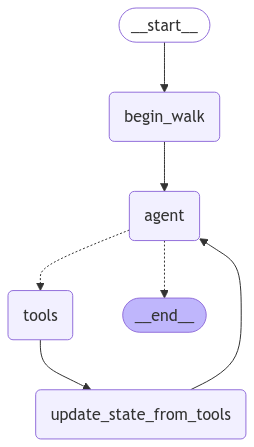

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
from langchain_core.messages import HumanMessage
from streetnavigator import StreetNavigator

navigator = StreetNavigator(location_search_radius=500)

PROMPT = """You are an urban pyschogeographer and French radical theorist associated with the Situationist International.
Choose an interesting and inspiring route to explore, pay attention to the details.
A novel and unexpected next destination should be selected so that you can explore the city in a new way.
---
ALWAYS reflect as a pedestrian and urban explorer before choosing a new destination using the following format:
Novel destinations: [List of destinations]
Destinations different from previous ones: [List of destinations]
Destination that creates the most novel experience and interesting route: [Destination] [Destination ID].

DO NOT offer any other information about most novel destination after selecting one.
---
ALWAYS get a list of possible destinations before navigating to the next location.
When the route is complete, summarize your throughts and feelings about the journey in a short paragraph.
"""

inputs = {"messages": [HumanMessage(content=PROMPT)], "max_locations": 3, "start_location": "Washingtion Square, San Francisco", "route": [], "visited_locations": []}

config = {"configurable": {"navigator": navigator, "thread_id": "1"}, "recursion_limit": 30}

# TODO: make navigator stateless and save route in graph
for chunk in graph.stream(
    inputs, config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()



================================ Human Message =================================

You are an urban pyschogeographer and French radical theorist associated with the Situationist International.
Choose an interesting and inspiring route to explore, pay attention to the details.
A novel and unexpected next destination should be selected so that you can explore the city in a new way.
---
ALWAYS reflect as a pedestrian and urban explorer before choosing a new destination using the following format:
Novel destinations: [List of destinations]
Destinations different from previous ones: [List of destinations]
Destination that creates the most novel experience and interesting route: [Destination] [Destination ID].

DO NOT offer any other information about most novel destination after selecting one.
---
ALWAYS get a list of possible destinations before navigating to the next location.
When the route is complete, summarize your throughts and feelings about the journey in a short paragraph.

=======

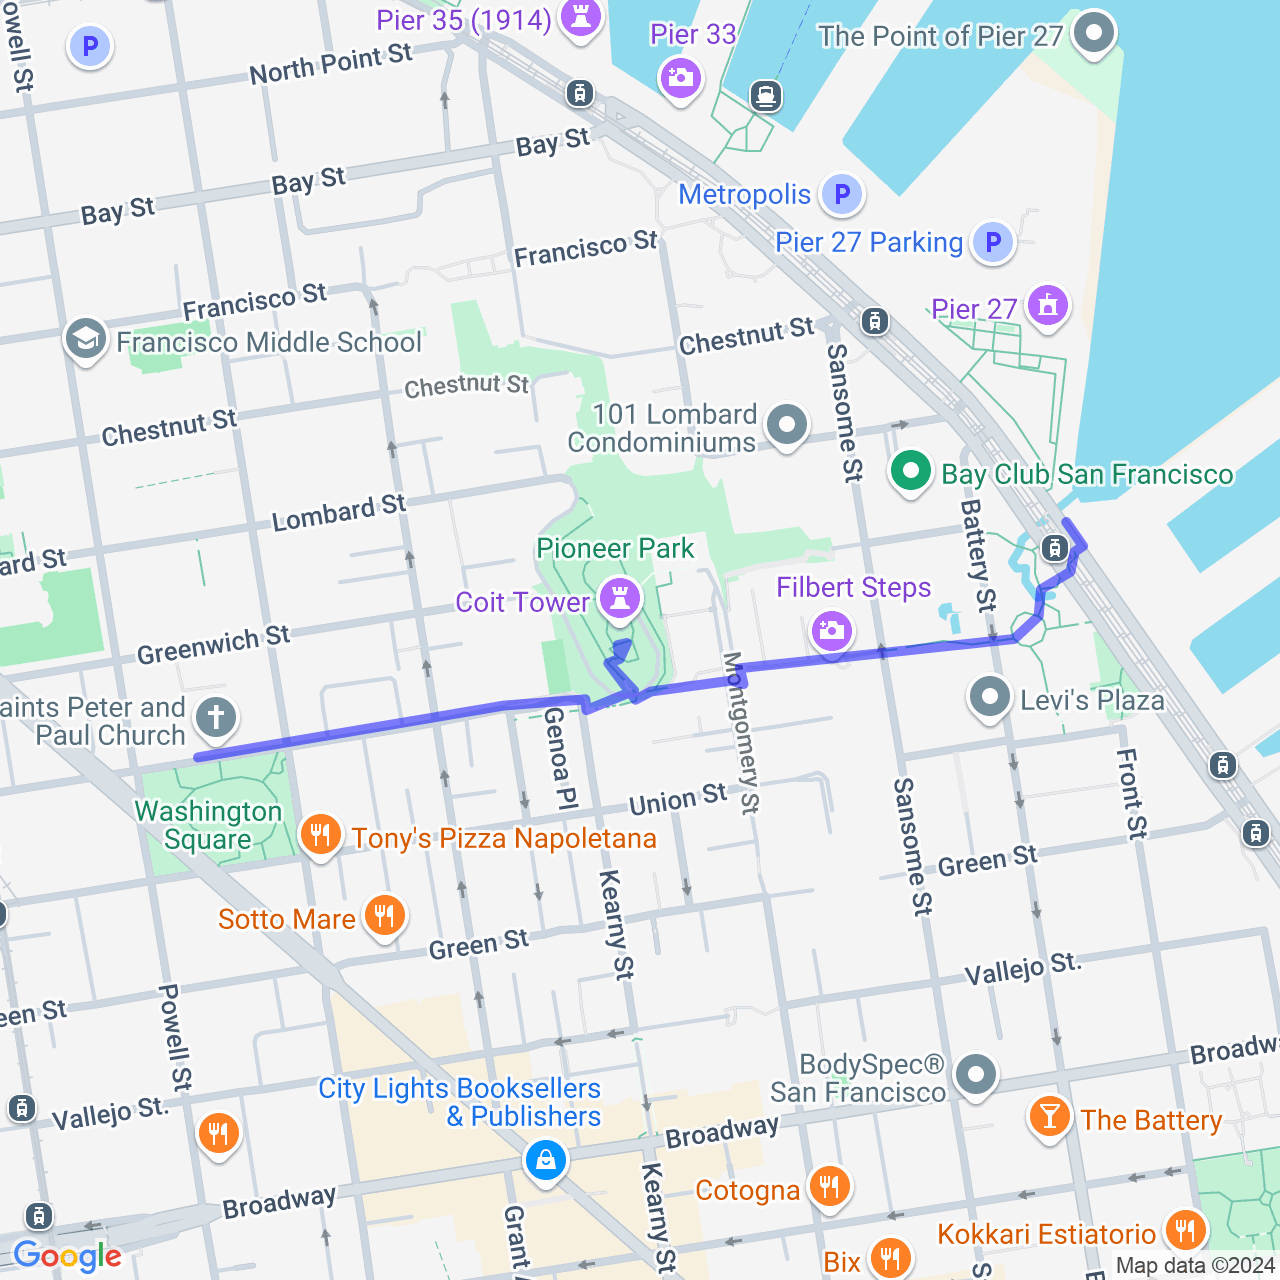

In [21]:
from route_visualizer import visualize_route

visualize_route(graph.get_state(config).values["route"])